# 'You seem familiar' - One-shot approach to tackle kinship problem

In this notebook we are going to solve this kinship problem using the popular one-shot learning approach and build a embedding generator to find the cosine-similarity amongst the images of people from a family. Playing with cosine similarity, we are going to design a model that is able to recognize the people of a family and people related by blood.

### Understanding the dataset
The dataset comprises of files seperated into training and testing folders with a relation dataframe _train_relationships.csv_ pointing to the images of blood related members.
Files stored in the train folder are as follows:
    
```bash
./train
./train/F@@@@      - @@@@ denoting the family number
./train/F@@@@/MID$ - $ denoting the member of the family
```
Example:

```bash
   +---------------+------------+
   | F0002/MID1    | F0002/MID3 |
   | F0002/MID2	| F0002/MID3 |
   +---------------+------------+
```
This represents that member _MID1_ and _MID2_ of family _F0002_ is in blood relation with _MID3_ whereas _MID1_ and _MID2_ are not in blood-relationship with each other.

In [317]:
# calling basic imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plotting library
from matplotlib import pyplot as plt
import seaborn as sns

# Additional support libraries
import os
print(os.listdir("./"))

# Library for reading images 
from PIL import Image

# Random
import random
from tqdm import tqdm_notebook

import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation

from scipy.misc import imread, imresize
import datetime

['.ipynb_checkpoints', 'Challange.ipynb', 'Models', 'one-shot-method-to-tackle-kinship-problem-3b6944.ipynb', 'sample_submission.csv', 'simple-autoencoder-keras-and-kmean-cluster.ipynb', 'SmileLab2.ipynb', 'SmileLabKernelCopy.ipynb', 'submission.csv', 'submission_Old.csv', 'test', 'test.zip', 'train', 'train.zip', 'train_DF.csv', 'train_images.txt', 'train_relationships.csv', 'train_relationships_.csv', 'val_relationships.csv', 'vgg-face-keras.h5']


In [318]:
TRAIN_BASE = './train/'
families = sorted(os.listdir(TRAIN_BASE))
print('We have {} families in the dataset'.format(len(families)))
print(families[:5])

We have 470 families in the dataset
['F0002', 'F0005', 'F0009', 'F0010', 'F0016']


In [319]:
members = {i:sorted(os.listdir(TRAIN_BASE+i)) for i in families}

In [320]:
TEST_BASE='./test/'
test_images_names = os.listdir(TEST_BASE)
test_images_names[:5]

['face00000.jpg',
 'face00001.jpg',
 'face00002.jpg',
 'face00003.jpg',
 'face00004.jpg']

In [321]:
#def load_img(PATH): return np.array(Image.open(PATH))
#test_images=np.array([load_img(os.path.join(TEST_BASE,image)) for image in test_images_names])

In [322]:
#test_images.shape

# Read and Clean the data
Some of the paths mentioned in the excel sheet is not existing, and some of the folders in the training set is empty. Drop all of them.

In [323]:
train_DF  = pd.read_csv('./train_relationships.csv')
TRAINING_BASE = "./train/"
#print(train_DF.head())
print(len(train_DF))
#for item in range(len(train_DF)):
for i, row in train_DF.iterrows():
    if(not(os.path.exists(TRAINING_BASE + row.p1))) or (not(os.path.exists(TRAINING_BASE + row.p2))):
        row.p1 = "NA"
        row.p2 = "NA"
        
train_DF = train_DF[train_DF.p1 != "NA"]
train_DF = train_DF[train_DF.p2 != "NA"]
train_DF.reset_index(inplace=True, drop=True)

#print(len(train_DF))
#for i, row in train_DF.iterrows():
#    if(not(os.path.exists(TRAINING_BASE + row.p2))):
#        train_DF.drop(train_DF.index[i], inplace=True)
#train_DF.reset_index(inplace=True, drop=True)

for i, row in train_DF.iterrows():
    imgs1 = os.listdir(TRAINING_BASE + row.p1)
    if(len(imgs1) == 0):
        #train_DF.drop(train_DF.index[i], inplace=True, axis=0)
        row.p1 = "NA"
        row.p2 = "NA"
        
train_DF = train_DF[train_DF.p1 != "NA"]
train_DF = train_DF[train_DF.p2 != "NA"]
train_DF.reset_index(inplace=True, drop=True)

for i, row in train_DF.iterrows():
    imgs2 = os.listdir(TRAINING_BASE + row.p2)
    if(len(imgs2) == 0):
        #train_DF.drop(train_DF.index[i], inplace=True, axis=0)
        row.p1 = "NA"
        row.p2 = "NA"
        
train_DF = train_DF[train_DF.p1 != "NA"]
train_DF = train_DF[train_DF.p2 != "NA"]
train_DF.reset_index(inplace=True, drop=True)

print(len(train_DF))

3598
3362


# Split the data into training and Validation - 70:30

In [324]:
from sklearn import cross_validation

train, val = cross_validation.train_test_split(train_DF, test_size=0.3, random_state=0)

number = len(train)
print(number)
print(train.tail())
print(val.tail())
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

2353
              p1          p2
835   F0254/MID3  F0254/MID1
3264  F0984/MID1  F0984/MID3
1653  F0530/MID3  F0530/MID4
2607  F0784/MID1  F0784/MID3
2732  F0811/MID4  F0811/MID8
               p1           p2
1495   F0460/MID4   F0460/MID5
2971   F0874/MID4   F0874/MID5
1931  F0601/MID32  F0601/MID30
619    F0197/MID1   F0197/MID5
2060   F0642/MID4   F0642/MID1


# Read all the paths

Read all the paths needed for the generator

In [325]:
training_doc = np.random.permutation(open('train_relationships.csv').readlines())

# Generator Function
Generator function is needed to reduce the RAM usage

In [326]:
#import skimage
batch_size = 10
def generator(source_path, batch_size, net_type, folder_list=train, rows=1):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    tdf = folder_list[:rows]
    while True:
        tf1 = tdf.p1
        tf2 = tdf.p2
        num_batches =  len(tf1) // batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, 3, 224, 224))
            batch_labels = np.zeros((batch_size,2))
            for folder in range(batch_size):
                imgs1 = os.listdir(source_path + tf1[folder + (batch*batch_size)])
                imgs2 = os.listdir(source_path + tf2[folder + (batch*batch_size)])
                for item in range(10):
                    image1 = imread(source_path + tf1[folder + (batch*batch_size)]+'/' + random.choice(imgs1)).astype(np.float32)
                    image1 = image1.transpose((2,0,1))
                    image1 = np.expand_dims(image1, axis=0)
                    image2 = imread(source_path + tf2[folder + (batch*batch_size)]+'/' + random.choice(imgs2)).astype(np.float32)
                    image2 = image2.transpose((2,0,1))
                    image2 = np.expand_dims(image2, axis=0)

                    #res_image1=np.resize(image1, (3, 112, 224))
                    #res_image2=np.resize(image2, (3, 112, 224))
                    res_image1 = np.concatenate([image1, image2])
                    res_image=np.resize(res_image1, (3, 224, 224))
                    
                    batch_data[folder,0,:,:] = (res_image[0,:,:] - res_image[0,:,:].mean()) / res_image[0,:,:].std()
                    batch_data[folder, 1,:,:] = (res_image[1,:,:] - res_image[1,:,:].mean()) / res_image[1,:,:].std()
                    batch_data[folder, 2,:,:] = (res_image[2,:,:] - res_image[2,:,:].mean()) / res_image[2,:,:].std()

                    batch_labels[folder, 0] = 1
                    
            yield batch_data, batch_labels

        
        # write the code for the remaining data points which are left after full batches
        rem_batches =  len(folder_list) % batch_size
        for batch in range(rem_batches):
            batch_data = np.zeros((batch_size, 3, 224, 224))
            batch_labels = np.zeros((batch_size,2))
            for folder in range(batch_size):
                imgs1 = os.listdir(source_path + tf1[folder + (batch*batch_size)])
                imgs2 = os.listdir(source_path + tf2[folder + (batch*batch_size)])
                for item in range(10):
                    image1 = imread(source_path + tf1[folder + (batch*batch_size)]+'/' + random.choice(imgs1)).astype(np.float32)
                    image1 = image1.transpose((2,0,1))
                    image1 = np.expand_dims(image1, axis=0)
                    image2 = imread(source_path + tf2[folder + (batch*batch_size)]+'/' + random.choice(imgs2)).astype(np.float32)
                    image2 = image2.transpose((2,0,1))
                    image2 = np.expand_dims(image2, axis=0)

                    #res_image1=np.resize(image1, (3, 112, 224))
                    #res_image2=np.resize(image2, (3, 112, 224))
                    res_image1 = np.concatenate([image1, image2])
                    res_image=np.resize(res_image1, (3, 224, 224))

                    batch_data[folder,0,:,:] = (res_image[0,:,:] - res_image[0,:,:].mean()) / res_image[0,:,:].std()
                    batch_data[folder, 1,:,:] = (res_image[1,:,:] - res_image[1,:,:].mean()) / res_image[1,:,:].std()
                    batch_data[folder, 2,:,:] = (res_image[2,:,:] - res_image[2,:,:].mean()) / res_image[2,:,:].std()

                    batch_labels[folder, 0] = 1
                
            yield batch_data, batch_labels

### Building the model

In order to generate the face embeddings, we are going to use the _vgg_face_ model trained on the faces dataset to generate images. We are going to use the _channel_first_ method in keras and change every image to channel first as per required. In order to change the keras configration to channel first, we are going to alter the _keras.json_ file in user home or by simply altering the backend.

In [327]:
from keras import backend as K

In [328]:
K.set_image_data_format('channels_first')

In [329]:
def model_face(weights_path=None):
    img = Input(shape=(3, 224, 224))

    pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
    conv1_1 = Convolution2D(64, (3, 3), activation='relu', name='conv1_1')(pad1_1)
    pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
    conv1_2 = Convolution2D(64, (3, 3), activation='relu', name='conv1_2')(pad1_2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

    pad2_1 = ZeroPadding2D((1, 1))(pool1)
    conv2_1 = Convolution2D(128, (3, 3), activation='relu', name='conv2_1')(pad2_1)
    pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
    conv2_2 = Convolution2D(128, (3, 3), activation='relu', name='conv2_2')(pad2_2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

    pad3_1 = ZeroPadding2D((1, 1))(pool2)
    conv3_1 = Convolution2D(256, (3, 3), activation='relu', name='conv3_1')(pad3_1)
    pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
    conv3_2 = Convolution2D(256, (3, 3), activation='relu', name='conv3_2')(pad3_2)
    pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
    conv3_3 = Convolution2D(256, (3, 3), activation='relu', name='conv3_3')(pad3_3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

    pad4_1 = ZeroPadding2D((1, 1))(pool3)
    conv4_1 = Convolution2D(512, (3, 3), activation='relu', name='conv4_1')(pad4_1)
    pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
    conv4_2 = Convolution2D(512, (3, 3), activation='relu', name='conv4_2')(pad4_2)
    pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
    conv4_3 = Convolution2D(512, (3, 3), activation='relu', name='conv4_3')(pad4_3)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

    pad5_1 = ZeroPadding2D((1, 1))(pool4)
    conv5_1 = Convolution2D(512, (3, 3), activation='relu', name='conv5_1')(pad5_1)
    pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
    conv5_2 = Convolution2D(512, (3, 3), activation='relu', name='conv5_2')(pad5_2)
    pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
    conv5_3 = Convolution2D(512, (3, 3), activation='relu', name='conv5_3')(pad5_3)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

    fc6 = Convolution2D(4096, (7, 7), activation='relu', name='fc6')(pool5)
    fc6_drop = Dropout(rate = 0.5)(fc6)
    fc7 = Convolution2D(4096,( 1, 1), activation='relu', name='fc7')(fc6_drop)
    fc7_drop = Dropout(rate = 0.5)(fc7)
    fc8 = Convolution2D(2, (1, 1), name='fc8')(fc7_drop)
    flat = Flatten()(fc8)
    out = Activation('softmax')(flat)

    model = Model(input=img, output=out)

    if weights_path:
        model.load_weights(weights_path)

    return model

In [330]:
faceModel = model_face()

D:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [331]:
optimiser ='sgd'
#@pk try different optimiser and document the observation. categorical_crossentropy ideal for this kind of problems
faceModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(faceModel.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_171 (ZeroPadd (None, 3, 226, 226)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_172 (ZeroPadd (None, 64, 226, 226)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_173 (ZeroPadd (None, 64, 114, 114)      0         
__________

In [332]:
# BS - Modified the fourth parameter to accomodate the generator to be used for Transfer Learning
train_generator = generator(TRAIN_BASE, batch_size,'CNN2D', train, rows=2000)
val_generator = generator(TRAIN_BASE, batch_size,'CNN2D', val, rows=1000)

In [333]:
from keras.models import Sequential, Model
from keras.layers import Dropout,Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import datetime
curr_dt_time = datetime.datetime.now()
model_name = 'Models/' + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, epsilon = 1e-04) # write the REducelronplateau code here
#@pk Have high patience. Specify other params epsilon, what to monitor (Val_Loss)
# ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, 
# verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
# min_lr = 0)

callbacks_list = [checkpoint, LR]

D:\Tools\Anaconda\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [334]:
num_train_sequences = len(train)
num_val_sequences = len(val)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [335]:
num_epochs = 5
cnn_training = faceModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5
Source path =  ./train/Source path =   ; batch size =./train/  10; batch size =
 10

D:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


D:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


140/236 [================>.............] - ETA: 7:24:10 - loss: 0.6935 - categorical_accuracy: 0.400 - ETA: 4:12:27 - loss: 0.6887 - categorical_accuracy: 0.700 - ETA: 3:06:36 - loss: 0.6840 - categorical_accuracy: 0.800 - ETA: 2:32:55 - loss: 0.6791 - categorical_accuracy: 0.850 - ETA: 2:12:20 - loss: 0.6744 - categorical_accuracy: 0.880 - ETA: 1:58:20 - loss: 0.6696 - categorical_accuracy: 0.900 - ETA: 1:48:26 - loss: 0.6648 - categorical_accuracy: 0.914 - ETA: 1:40:52 - loss: 0.6600 - categorical_accuracy: 0.925 - ETA: 1:34:56 - loss: 0.6554 - categorical_accuracy: 0.933 - ETA: 1:30:13 - loss: 0.6506 - categorical_accuracy: 0.940 - ETA: 1:26:17 - loss: 0.6458 - categorical_accuracy: 0.945 - ETA: 1:22:55 - loss: 0.6412 - categorical_accuracy: 0.950 - ETA: 1:20:05 - loss: 0.6365 - categorical_accuracy: 0.953 - ETA: 1:17:33 - loss: 0.6319 - categorical_accuracy: 0.957 - ETA: 1:15:22 - loss: 0.6274 - categorical_accuracy: 0.960 - ETA: 1:13:25 - loss: 0.6229 - categorical_accuracy: 0.962

189/236 [=======================>......] - ETA: 24:11 - loss: 0.1797 - categorical_accuracy: 0.995 - ETA: 23:54 - loss: 0.1784 - categorical_accuracy: 0.995 - ETA: 23:38 - loss: 0.1772 - categorical_accuracy: 0.995 - ETA: 23:22 - loss: 0.1760 - categorical_accuracy: 0.995 - ETA: 23:06 - loss: 0.1748 - categorical_accuracy: 0.995 - ETA: 22:50 - loss: 0.1736 - categorical_accuracy: 0.995 - ETA: 22:34 - loss: 0.1724 - categorical_accuracy: 0.995 - ETA: 22:18 - loss: 0.1712 - categorical_accuracy: 0.995 - ETA: 22:02 - loss: 0.1701 - categorical_accuracy: 0.996 - ETA: 21:46 - loss: 0.1689 - categorical_accuracy: 0.996 - ETA: 21:30 - loss: 0.1678 - categorical_accuracy: 0.996 - ETA: 21:14 - loss: 0.1667 - categorical_accuracy: 0.996 - ETA: 20:58 - loss: 0.1656 - categorical_accuracy: 0.996 - ETA: 20:42 - loss: 0.1646 - categorical_accuracy: 0.996 - ETA: 20:26 - loss: 0.1635 - categorical_accuracy: 0.996 - ETA: 20:11 - loss: 0.1625 - categorical_accuracy: 0.996 - ETA: 19:55 - loss: 0.1614 - c

D:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
D:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


236/236 [==============================] - ETA: 11:25 - loss: 0.1334 - categorical_accuracy: 0.996 - ETA: 11:10 - loss: 0.1327 - categorical_accuracy: 0.996 - ETA: 10:55 - loss: 0.1320 - categorical_accuracy: 0.996 - ETA: 10:40 - loss: 0.1314 - categorical_accuracy: 0.996 - ETA: 10:25 - loss: 0.1307 - categorical_accuracy: 0.996 - ETA: 10:10 - loss: 0.1300 - categorical_accuracy: 0.996 - ETA: 9:56 - loss: 0.1294 - categorical_accuracy: 0.996 - ETA: 9:41 - loss: 0.1287 - categorical_accuracy: 0.99 - ETA: 9:26 - loss: 0.1281 - categorical_accuracy: 0.99 - ETA: 9:11 - loss: 0.1274 - categorical_accuracy: 0.99 - ETA: 8:56 - loss: 0.1268 - categorical_accuracy: 0.99 - ETA: 8:41 - loss: 0.1261 - categorical_accuracy: 0.99 - ETA: 8:26 - loss: 0.1255 - categorical_accuracy: 0.99 - ETA: 8:11 - loss: 0.1249 - categorical_accuracy: 0.99 - ETA: 7:56 - loss: 0.1243 - categorical_accuracy: 0.99 - ETA: 7:41 - loss: 0.1237 - categorical_accuracy: 0.99 - ETA: 7:26 - loss: 0.1231 - categorical_accuracy:

132/236 [===============>..............] - ETA: 54:11 - loss: 1.5488e-04 - categorical_accuracy: 1.000 - ETA: 55:41 - loss: 1.3058e-04 - categorical_accuracy: 1.000 - ETA: 55:28 - loss: 1.2506e-04 - categorical_accuracy: 1.000 - ETA: 55:09 - loss: 1.3304e-04 - categorical_accuracy: 1.000 - ETA: 54:39 - loss: 1.3195e-04 - categorical_accuracy: 1.000 - ETA: 54:20 - loss: 1.4196e-04 - categorical_accuracy: 1.000 - ETA: 54:06 - loss: 1.3894e-04 - categorical_accuracy: 1.000 - ETA: 53:50 - loss: 1.5236e-04 - categorical_accuracy: 1.000 - ETA: 53:39 - loss: 1.5258e-04 - categorical_accuracy: 1.000 - ETA: 53:26 - loss: 1.5078e-04 - categorical_accuracy: 1.000 - ETA: 53:23 - loss: 1.4806e-04 - categorical_accuracy: 1.000 - ETA: 53:12 - loss: 1.4489e-04 - categorical_accuracy: 1.000 - ETA: 53:02 - loss: 1.4456e-04 - categorical_accuracy: 1.000 - ETA: 52:55 - loss: 1.3864e-04 - categorical_accuracy: 1.000 - ETA: 52:36 - loss: 1.3782e-04 - categorical_accuracy: 1.000 - ETA: 52:19 - loss: 1.3543e-

236/236 [==============================] - ETA: 24:53 - loss: 9.3070e-05 - categorical_accuracy: 1.000 - ETA: 24:38 - loss: 9.3062e-05 - categorical_accuracy: 1.000 - ETA: 24:23 - loss: 9.2719e-05 - categorical_accuracy: 1.000 - ETA: 24:08 - loss: 9.2476e-05 - categorical_accuracy: 1.000 - ETA: 23:53 - loss: 9.2417e-05 - categorical_accuracy: 1.000 - ETA: 23:38 - loss: 9.2012e-05 - categorical_accuracy: 1.000 - ETA: 23:23 - loss: 9.1875e-05 - categorical_accuracy: 1.000 - ETA: 23:08 - loss: 9.1702e-05 - categorical_accuracy: 1.000 - ETA: 22:53 - loss: 9.1441e-05 - categorical_accuracy: 1.000 - ETA: 22:38 - loss: 9.1128e-05 - categorical_accuracy: 1.000 - ETA: 22:23 - loss: 9.0790e-05 - categorical_accuracy: 1.000 - ETA: 22:09 - loss: 9.0435e-05 - categorical_accuracy: 1.000 - ETA: 21:54 - loss: 9.0379e-05 - categorical_accuracy: 1.000 - ETA: 21:39 - loss: 9.0105e-05 - categorical_accuracy: 1.000 - ETA: 21:24 - loss: 8.9907e-05 - categorical_accuracy: 1.000 - ETA: 21:10 - loss: 8.9673e-

132/236 [===============>..............] - ETA: 1:05:15 - loss: 2.5493e-05 - categorical_accuracy: 1.000 - ETA: 1:02:02 - loss: 3.7076e-05 - categorical_accuracy: 1.000 - ETA: 1:01:08 - loss: 3.9440e-05 - categorical_accuracy: 1.000 - ETA: 1:00:33 - loss: 3.7341e-05 - categorical_accuracy: 1.000 - ETA: 1:00:03 - loss: 4.4627e-05 - categorical_accuracy: 1.000 - ETA: 59:40 - loss: 4.3926e-05 - categorical_accuracy: 1.0000  - ETA: 59:14 - loss: 5.0070e-05 - categorical_accuracy: 1.000 - ETA: 59:28 - loss: 5.1168e-05 - categorical_accuracy: 1.000 - ETA: 59:46 - loss: 4.7454e-05 - categorical_accuracy: 1.000 - ETA: 59:39 - loss: 4.7786e-05 - categorical_accuracy: 1.000 - ETA: 59:29 - loss: 4.6823e-05 - categorical_accuracy: 1.000 - ETA: 59:21 - loss: 4.5760e-05 - categorical_accuracy: 1.000 - ETA: 59:06 - loss: 4.4723e-05 - categorical_accuracy: 1.000 - ETA: 58:32 - loss: 4.4880e-05 - categorical_accuracy: 1.000 - ETA: 58:06 - loss: 4.5653e-05 - categorical_accuracy: 1.000 - ETA: 57:36 - lo

236/236 [==============================] - ETA: 24:26 - loss: 3.7368e-05 - categorical_accuracy: 1.000 - ETA: 24:11 - loss: 3.7336e-05 - categorical_accuracy: 1.000 - ETA: 23:57 - loss: 3.7252e-05 - categorical_accuracy: 1.000 - ETA: 23:43 - loss: 3.7258e-05 - categorical_accuracy: 1.000 - ETA: 23:28 - loss: 3.7114e-05 - categorical_accuracy: 1.000 - ETA: 23:14 - loss: 3.7142e-05 - categorical_accuracy: 1.000 - ETA: 23:01 - loss: 3.7171e-05 - categorical_accuracy: 1.000 - ETA: 22:46 - loss: 3.7021e-05 - categorical_accuracy: 1.000 - ETA: 22:32 - loss: 3.6919e-05 - categorical_accuracy: 1.000 - ETA: 22:18 - loss: 3.6789e-05 - categorical_accuracy: 1.000 - ETA: 22:04 - loss: 3.6772e-05 - categorical_accuracy: 1.000 - ETA: 21:49 - loss: 3.6664e-05 - categorical_accuracy: 1.000 - ETA: 21:35 - loss: 3.6559e-05 - categorical_accuracy: 1.000 - ETA: 21:20 - loss: 3.6551e-05 - categorical_accuracy: 1.000 - ETA: 21:06 - loss: 3.6489e-05 - categorical_accuracy: 1.000 - ETA: 20:52 - loss: 3.6323e-

132/236 [===============>..............] - ETA: 51:48 - loss: 2.5476e-05 - categorical_accuracy: 1.000 - ETA: 51:31 - loss: 2.3112e-05 - categorical_accuracy: 1.000 - ETA: 51:08 - loss: 2.0872e-05 - categorical_accuracy: 1.000 - ETA: 50:52 - loss: 2.0986e-05 - categorical_accuracy: 1.000 - ETA: 50:35 - loss: 2.4148e-05 - categorical_accuracy: 1.000 - ETA: 50:19 - loss: 2.7369e-05 - categorical_accuracy: 1.000 - ETA: 50:03 - loss: 2.6367e-05 - categorical_accuracy: 1.000 - ETA: 49:45 - loss: 2.7182e-05 - categorical_accuracy: 1.000 - ETA: 49:31 - loss: 2.6623e-05 - categorical_accuracy: 1.000 - ETA: 49:18 - loss: 2.5579e-05 - categorical_accuracy: 1.000 - ETA: 49:01 - loss: 2.5995e-05 - categorical_accuracy: 1.000 - ETA: 48:49 - loss: 2.5594e-05 - categorical_accuracy: 1.000 - ETA: 48:37 - loss: 2.5395e-05 - categorical_accuracy: 1.000 - ETA: 48:23 - loss: 2.4860e-05 - categorical_accuracy: 1.000 - ETA: 48:13 - loss: 2.4547e-05 - categorical_accuracy: 1.000 - ETA: 47:58 - loss: 2.5299e-

236/236 [==============================] - ETA: 23:44 - loss: 2.0688e-05 - categorical_accuracy: 1.000 - ETA: 23:31 - loss: 2.0638e-05 - categorical_accuracy: 1.000 - ETA: 23:17 - loss: 2.0663e-05 - categorical_accuracy: 1.000 - ETA: 23:03 - loss: 2.0616e-05 - categorical_accuracy: 1.000 - ETA: 22:49 - loss: 2.0602e-05 - categorical_accuracy: 1.000 - ETA: 22:35 - loss: 2.0669e-05 - categorical_accuracy: 1.000 - ETA: 22:21 - loss: 2.0717e-05 - categorical_accuracy: 1.000 - ETA: 22:07 - loss: 2.0775e-05 - categorical_accuracy: 1.000 - ETA: 21:54 - loss: 2.0807e-05 - categorical_accuracy: 1.000 - ETA: 21:40 - loss: 2.0759e-05 - categorical_accuracy: 1.000 - ETA: 21:26 - loss: 2.0734e-05 - categorical_accuracy: 1.000 - ETA: 21:12 - loss: 2.0771e-05 - categorical_accuracy: 1.000 - ETA: 20:58 - loss: 2.0781e-05 - categorical_accuracy: 1.000 - ETA: 20:44 - loss: 2.0955e-05 - categorical_accuracy: 1.000 - ETA: 20:30 - loss: 2.0940e-05 - categorical_accuracy: 1.000 - ETA: 20:17 - loss: 2.0914e-

132/236 [===============>..............] - ETA: 53:29 - loss: 2.5577e-05 - categorical_accuracy: 1.000 - ETA: 57:06 - loss: 1.8093e-05 - categorical_accuracy: 1.000 - ETA: 59:38 - loss: 1.9066e-05 - categorical_accuracy: 1.000 - ETA: 59:53 - loss: 1.9903e-05 - categorical_accuracy: 1.000 - ETA: 59:05 - loss: 1.8347e-05 - categorical_accuracy: 1.000 - ETA: 58:56 - loss: 1.7174e-05 - categorical_accuracy: 1.000 - ETA: 58:29 - loss: 1.7526e-05 - categorical_accuracy: 1.000 - ETA: 57:54 - loss: 1.7053e-05 - categorical_accuracy: 1.000 - ETA: 57:41 - loss: 1.7520e-05 - categorical_accuracy: 1.000 - ETA: 58:15 - loss: 1.7054e-05 - categorical_accuracy: 1.000 - ETA: 58:46 - loss: 1.6445e-05 - categorical_accuracy: 1.000 - ETA: 59:07 - loss: 1.6175e-05 - categorical_accuracy: 1.000 - ETA: 59:41 - loss: 1.6362e-05 - categorical_accuracy: 1.000 - ETA: 59:09 - loss: 1.5909e-05 - categorical_accuracy: 1.000 - ETA: 58:33 - loss: 1.5377e-05 - categorical_accuracy: 1.000 - ETA: 58:02 - loss: 1.4753e-

236/236 [==============================] - ETA: 25:24 - loss: 1.4660e-05 - categorical_accuracy: 1.000 - ETA: 25:08 - loss: 1.4738e-05 - categorical_accuracy: 1.000 - ETA: 24:53 - loss: 1.4689e-05 - categorical_accuracy: 1.000 - ETA: 24:37 - loss: 1.4709e-05 - categorical_accuracy: 1.000 - ETA: 24:22 - loss: 1.4746e-05 - categorical_accuracy: 1.000 - ETA: 24:07 - loss: 1.4697e-05 - categorical_accuracy: 1.000 - ETA: 23:51 - loss: 1.4670e-05 - categorical_accuracy: 1.000 - ETA: 23:36 - loss: 1.4705e-05 - categorical_accuracy: 1.000 - ETA: 23:20 - loss: 1.4667e-05 - categorical_accuracy: 1.000 - ETA: 23:05 - loss: 1.4749e-05 - categorical_accuracy: 1.000 - ETA: 22:50 - loss: 1.4759e-05 - categorical_accuracy: 1.000 - ETA: 22:35 - loss: 1.4814e-05 - categorical_accuracy: 1.000 - ETA: 22:20 - loss: 1.4833e-05 - categorical_accuracy: 1.000 - ETA: 22:04 - loss: 1.4762e-05 - categorical_accuracy: 1.000 - ETA: 21:49 - loss: 1.4740e-05 - categorical_accuracy: 1.000 - ETA: 21:34 - loss: 1.4738e-

In [38]:
curr_dt_time = datetime.datetime.now()
print(curr_dt_time)
faceModel.load_weights("Models/model_init_2019-08-0800_05_39.739717/model-00005-0.00001-1.00000-0.00000-1.00000.h5")

2019-08-08 12:45:21.107558


Now let's try to generate the embeddings for 2 images from the dataset

In [339]:
im = Image.open('./train/F0002/MID1/P00009_face3.jpg')
im = np.array(im).astype(np.float32)
im2 = Image.open('./train/F0002/MID2/P00011_face2.jpg')
im2 = np.array(im2).astype(np.float32)
im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)
im2 = im2.transpose((2,0,1))
im2 = np.expand_dims(im2, axis=0)
im3 = np.concatenate([im,im2])
im4 = np.concatenate([im2, im])
im_final = np.concatenate([im3, im4], axis = 1)
resultant_image=np.resize(im_final, (2, 3, 224, 224))
resultant_image.shape

(2, 3, 224, 224)

In [340]:
out = faceModel.predict(resultant_image)
print(out)

[[1. 0.]
 [1. 0.]]


In [341]:
def cosine_similarity(a,b):
    return np.sum(np.multiply(a,b))/np.multiply( np.sqrt(np.sum(np.power(a,2))),(np.sqrt(np.sum(np.power(b,2)))))

def distance(x, y):
    return np.linalg.norm(x - y)

In [343]:
print(cosine_similarity(out[0], out[1]), distance(out[0], out[1]))

1.0 0.0


Now finally reading the testset from the test_folder and predicting on the values from sample submission.

In [344]:
def load_img(PATH): return np.array(Image.open(PATH))
test_images = os.listdir(TEST_BASE)
test = np.array([load_img(os.path.join(TEST_BASE, i)) for i in test_images])
test_emb = faceModel.predict(test.transpose(0,3,1,2))
print(test.shape, test_emb.shape)

(6282, 224, 224, 3) (6282, 2)


In [345]:
image_mapping = {img:idx for idx, img in enumerate(test_images)}

In [346]:
submission = pd.read_csv('./sample_submission.csv')
req_mapping = [i.split('-') for i in submission.img_pair]

In [347]:
vector_distances=[]
for i in req_mapping:
    a = i[0]
    b = i[1]
    dis = distance(test_emb[image_mapping[a]], test_emb[image_mapping[b]])
    vector_distances.append(dis)
vector_distances=np.array(vector_distances)

In [348]:
total_sum = vector_distances.sum()

Now from the vector_distances we have calulated above, we are now going to transform these distances into probablity of being same.

In [349]:
probs = []
for dist in vector_distances:
    prob = np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum
    probs.append(1 - prob)

D:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in float_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [350]:
vector_distances.shape

(5310,)

In [351]:
np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum

D:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in float_scalars
  """Entry point for launching an IPython kernel.


nan

In [352]:
submission.is_related = probs

In [353]:
submission.to_csv('submission.csv', index=False)

In [354]:
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,NaN
1,face05750.jpg-face00898.jpg,NaN
2,face05820.jpg-face03938.jpg,NaN
3,face02104.jpg-face01172.jpg,NaN
4,face02428.jpg-face05611.jpg,NaN


In [355]:
test_emb.shape

(6282, 2)

In [356]:
import sklearn.manifold


In [357]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_emb_matrix_2d = tsne.fit_transform(test_emb)

In [358]:
points = pd.DataFrame(
    [
        (name, coords[0], coords[1])
        for name, coords in [
            (img, all_emb_matrix_2d[image_mapping[img]])
            for img in test_images
        ]
    ],
    columns=["name", "x", "y"]
)

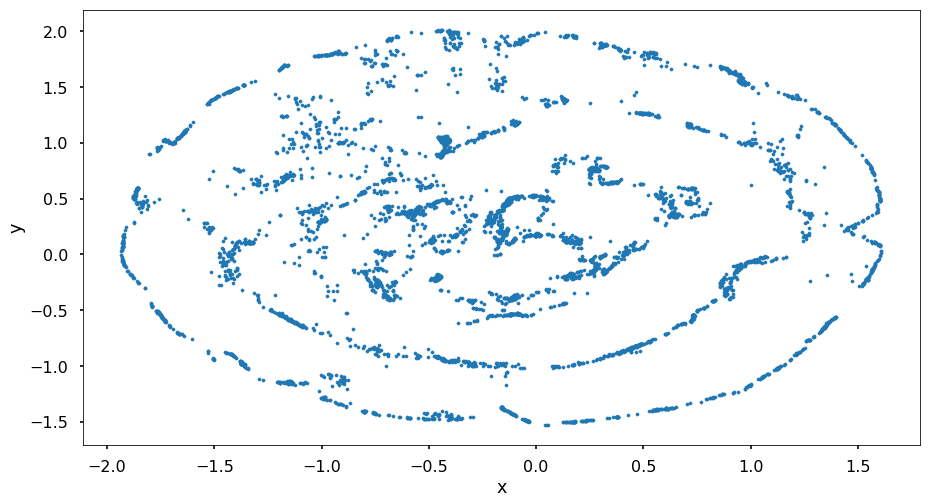

In [63]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(15, 8))

In [44]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

AttributeError: 'Series' object has no attribute 'word'

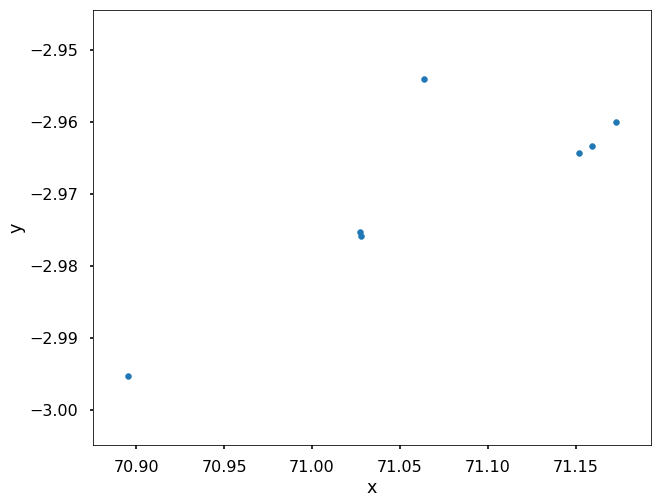

In [46]:
plot_region(x_bounds=(70.0, 80.0), y_bounds=(-10.0, 0.0))

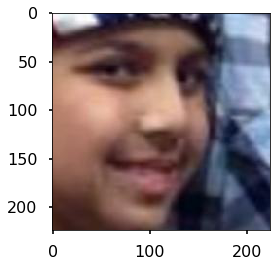

In [47]:
plt.imshow(test[image_mapping['face'+'03198'+'.jpg']])

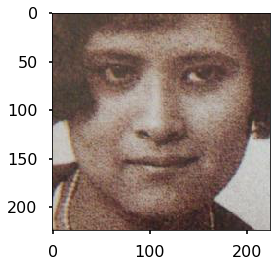

In [48]:
plt.imshow(test[image_mapping['face'+'05866'+'.jpg']])